Testing whether a y-dependence is necessary. The results show that the 'extra' parameter is consistent with zero, i.e. no y-dependent jitter is necessary.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import corner
import emcee

Define various functions for MCMC

In [3]:
def model(pars, x):
    return pars[0] * x + pars[1]

In [4]:
def simple_lnprior(pars):
    if -10 < pars[0] < 10 and -10 < pars[1] < 10 and -10 < pars[2] < 10:
        return 0.
    else:
        return -np.inf

In [5]:
def lnprior(pars, mm=False):
    if -10 < pars[0] < 10 and -10 < pars[1] < 10 and -10 < pars[2] < 10 \
            and -10 < pars[3] < 10:
        return 0.
    return -np.inf

In [6]:
def lnprob(pars, x, y, yerr):
    return lnprior(pars) + lnlike(pars, x, y, yerr)

In [7]:
def simple_lnlike(pars, x, y, yerr):
    invsig2 = 1./(yerr**2 + np.exp(2*pars[2]))
    model_y = model(pars, x)
    return -.5*np.sum((y-model_y)**2*invsig2 - np.log(invsig2))

In [8]:
def lnlike(pars, x, y, yerr):
    invsig2 = 1./(yerr**2 + (pars[2] + pars[3]*y)**2)  # modelling as sigma, not variance
    model_y = model(pars, x)
    return -.5*np.sum((y-model_y)**2*invsig2 - np.log(invsig2))

Load and plot data with best-fit line

params =  -0.525509606298 2.88909102256


/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


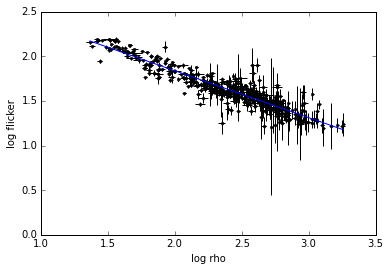

In [9]:
# load data
f, ferr, r, rerr = np.genfromtxt("../data/flickers.dat").T

# fit a line
AT = np.vstack((r, np.ones_like(r)))
ATA = np.dot(AT, AT.T)
m, c = np.linalg.solve(ATA, np.dot(AT, f))
print("params = ", m, c)

# plot data with best fit line
xs = np.linspace(min(r), max(r), 100)
ys = m * xs + c
plt.errorbar(r, f, xerr=rerr, yerr=ferr, fmt="k.", capsize=0)
plt.plot(xs, ys)
plt.ylabel("log flicker")
plt.xlabel("log rho")

Define initial parameters and test the lhf works

In [43]:
pars_init = [m, c, .06, 0.]
print(lnlike(pars_init, r, f, ferr)) # check the lhf works

874.396726885


Run emcee for 100,000 steps

In [44]:
ndim, nwalkers = len(pars_init), 24
pos = [pars_init + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]  # initialisation
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(r, f, ferr))
sampler.run_mcmc(pos, 100000)  # run MCMC

(array([[ -5.22119410e-01,   2.87996844e+00,   4.41447963e-02,
           1.24136542e-02],
        [ -5.46161603e-01,   2.93703942e+00,   1.10983404e-01,
          -2.53681134e-02],
        [ -5.16833613e-01,   2.86320158e+00,   9.76526779e-03,
           3.26917326e-02],
        [ -5.20596339e-01,   2.86917458e+00,   3.60082518e-02,
           1.65410124e-02],
        [ -5.02990805e-01,   2.84453464e+00,   6.73794168e-02,
          -2.19305287e-03],
        [ -5.16142423e-01,   2.86278342e+00,  -1.18421793e-02,
           4.88473569e-02],
        [ -5.09333974e-01,   2.84919755e+00,   2.24058086e-02,
           2.72091495e-02],
        [ -5.25076975e-01,   2.88858968e+00,   5.26676592e-02,
           4.99253585e-03],
        [ -5.26757449e-01,   2.90279025e+00,   6.37388457e-02,
           1.02694206e-03],
        [ -5.25973921e-01,   2.89489702e+00,   5.75117640e-02,
           3.48287129e-03],
        [ -5.13436838e-01,   2.86177608e+00,   7.96841054e-02,
          -9.44989520e-03],

Plot the results

/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


ERROR! Session/line number was not unique in database. History logging moved to new session 59


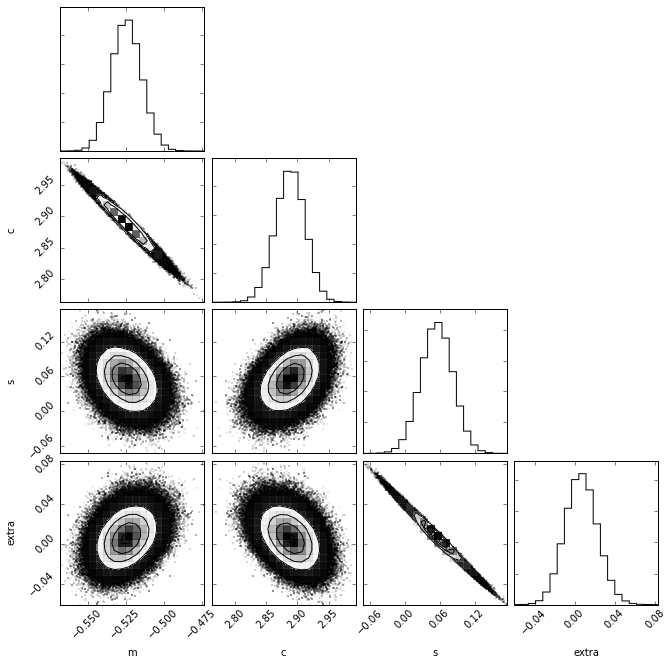

In [45]:
samples = sampler.chain[:, 50000:, :].reshape((-1, ndim))  # cut off burn in and flatten chains
m1, c1, s1, extra = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))
fig = corner.corner(samples, labels=["m", "c", "s", "extra"])

Print the results

In [47]:
print(s1)
print(extra)

(0.055065225421322528, 0.027213065878079382, 0.027416573159294126)
(0.0064397024807734456, 0.016196617566821378, 0.015769613126424289)


`extra' is consistent with zero, therefore no y-dependence is necessary

Now repeat the above for log g

-0.826618949099 4.90659568177


/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


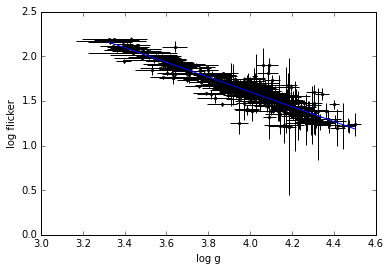

In [9]:
# load data
f, ferr, l, lerr, _, _ = np.genfromtxt("../data/log.dat").T

# fit a line
C = np.diag(ferr)
AT = np.vstack((l, np.ones_like(l)))
ATA = np.dot(AT, AT.T)
m, c = np.linalg.solve(ATA, np.dot(AT, f))
print(m, c)

# plot data
xs = np.linspace(min(l), max(l), 100)
ys = m * xs + c
plt.errorbar(l, f, xerr=lerr, yerr=ferr, fmt="k.", capsize=0)
plt.plot(xs, ys)
plt.ylabel("log flicker")
plt.xlabel("log g")

In [11]:
pars_init = [m, c, .06, 0.]
print(lnlike(pars_init, l, f, ferr)) # check the lhf works

908.618296047


In [12]:
ndim, nwalkers = len(pars_init), 24
pos = [pars_init + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]  # initialisation
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(l, f, ferr))
sampler.run_mcmc(pos, 100000)  # run MCMC

(array([[ -8.24787348e-01,   4.89923863e+00,   3.57410036e-02,
           1.44590166e-02],
        [ -8.52819847e-01,   5.00950916e+00,   1.31403683e-01,
          -4.24058798e-02],
        [ -8.10209849e-01,   4.84618860e+00,   5.87001276e-02,
           1.59111267e-03],
        [ -8.18086264e-01,   4.88128283e+00,   1.09453069e-01,
          -2.81813594e-02],
        [ -8.30189830e-01,   4.92489269e+00,   6.27179653e-02,
           4.69840612e-04],
        [ -8.13744669e-01,   4.86001613e+00,   6.65809549e-02,
          -4.13092896e-03],
        [ -8.31470319e-01,   4.93924019e+00,   1.34493736e-01,
          -4.05285359e-02],
        [ -8.08371834e-01,   4.83649444e+00,   5.19730728e-02,
           6.11376893e-03],
        [ -8.20233294e-01,   4.88375863e+00,   6.03690879e-02,
          -2.10518877e-03],
        [ -8.32558308e-01,   4.94071929e+00,   9.07336619e-02,
          -1.76581987e-02],
        [ -8.15994114e-01,   4.87474446e+00,   9.80228524e-02,
          -2.39967365e-02],

/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


(0.08229486404835365, 0.025225018990952669, 0.025663893621165362)
(-0.013625225125664048, 0.01495431134476251, 0.014366126754568899)


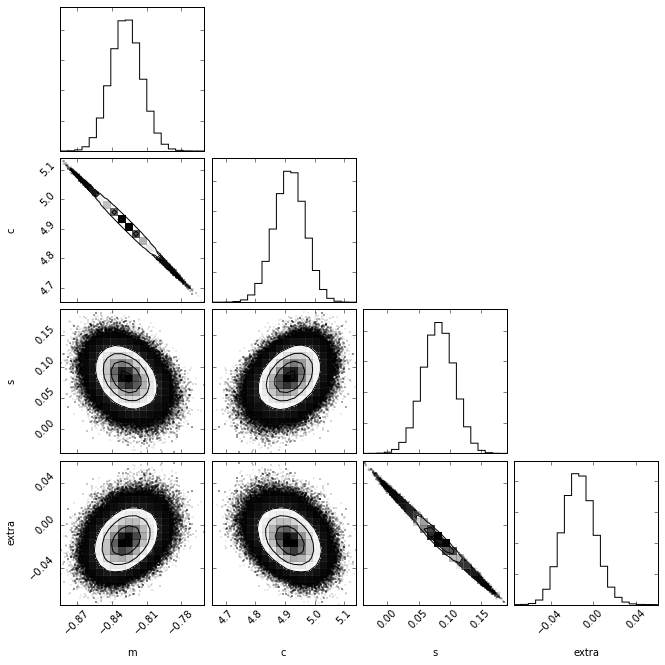

In [13]:
samples = sampler.chain[:, 50000:, :].reshape((-1, ndim))  # cut off burn in and flatten chains
m1, c1, s1, extra = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))
fig = corner.corner(samples, labels=["m", "c", "s", "extra"])
print(s1)
print(extra)